In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma as gamma_function
import math

In [332]:
class Cuckoo():
    
    X_min = 0
    X_max = 100
    alpha_min = 0.9
    alpha_max = 1.0
    pa_min = 0.05
    pa_max = 0.25
    N_nest = 25
    N_itertotal = 100
    gamma = 0.1          # noise factor
    lamda = 1.5          # constant used in le'vy flight
    
    total_nodes = 0
    anchor_percent = 0
    t_range = 0 # transmission range
    
    X_anchor = []
    X_unknown = []
    
    X_loc = []

    F_mins = []
    
    
    def __init__(self, total_nodes = 100, anchor_percent = 0.20, t_range = 25):
        self.total_nodes = total_nodes
        self.anchor_percent = anchor_percent
        self.t_range = t_range
        self.M = int(self.anchor_percent * self.total_nodes) # no. of anchor nodes
        self.N = self.total_nodes - self.M # no. of unknown nodes        
        
        for i in range(self.M):
            x_anchor = np.random.randint(100)
            y_anchor = np.random.randint(100)
            self.X_anchor.append([x_anchor, y_anchor])
        
        for i in range(self.N):
            x_unknown = np.random.randint(100)
            y_unknown = np.random.randint(100)
            self.X_unknown.append([x_unknown, y_unknown])
        
        self.X_unknown = np.array(self.X_unknown)
        self.X_anchor = np.array(self.X_anchor)
    
        self.X_anchor_og = self.X_anchor.copy()
        self.X_unknown_og = self.X_unknown.copy()
    
    def show_field(self):
        plt.figure(figsize=(8, 8))
        if len(self.X_unknown) != 0:
            plt.plot(self.X_unknown[:, 0], self.X_unknown[:, 1], 'yo', label="Left Node")
        plt.plot(self.X_unknown_og[:, 0], self.X_unknown_og[:, 1], 'ro', label='Unknown Node')
        plt.plot(self.X_anchor_og[:, 0], self.X_anchor_og[:, 1], 'go', label="Anchor Node")
        plt.plot(self.X_anchor[self.M:, 0], self.X_anchor[self.M:, 1], 'b^', label="Localized Node", fillstyle='none', markersize=10)
        plt.legend()
        plt.grid()
        plt.show()
        
        
    # step size (alpha)
    def alpha(self, n_iter):
        return self.alpha_max - ((n_iter/ self.N_itertotal) * (self.alpha_max - self.alpha_min)) # returns step size value

    # Le'vy flight function
    def levy(self):
        temp = np.power(((gamma_function(1 + self.lamda) * np.sin(np.pi * (self.lamda /2))) / (gamma_function((1 + self.lamda)/2) * self.lamda * np.power(2, ((self.lamda - 1)/2)) )), 1/self.lamda)
        u = np.random.normal(0, temp)
        v = np.random.normal(0,1)
        r = u / (np.power(abs(v), (1/self.lamda)))

        return r  # random walk value

    
    # location limit tester
    def limiter(self, point):
        x = point[0]
        y = point[1]
        if x > self.X_max and y > self.X_max:
            x,y = self.X_max, self.X_max
            # X_j = X_rand
        elif x > self.X_max and self.X_min < y < self.X_max:
            x,y = self.X_max, y
            # X_j = X_rand
        elif x > self.X_max and y < self.X_min:
            x,y = self.X_max, self.X_min
            # X_j = X_rand
        elif self.X_min < x < self.X_max and y < self.X_min:
            x,y = x, self.X_min
            # X_j = X_rand
        elif x < self.X_min and y < self.X_min:
            x,y = self.X_min, self.X_min
            # X_j = X_rand
        elif x < self.X_min and self.X_min < y < self.X_max:
            x,y = self.X_min, y
            # X_j = X_rand
        elif x < self.X_min and y > self.X_max:
            x,y = self.X_min, self.X_max
            # X_j = X_rand
        elif self.X_min < x < self.X_max and y > self.X_max:
            x,y = x, self.X_max
            # X_j = X_rand

        return [x,y]

    
    def neighbours(self, node, anchors):
        x = node[0]
        y = node[1]
        X_anchor = anchors
                
        l = []
        for j in range(len(X_anchor)): # for every anchor nodes
            dist_real = np.power((np.power((x - X_anchor[j][0]), 2) + np.power((y - X_anchor[j][1]), 2)), 0.5)
            np.random.seed(2)
            dist_err = dist_real + np.random.normal(0, (self.gamma*dist_real))
            np.random.seed()
            

            if dist_err < self.t_range:
                l.append(X_anchor[j])
                
        return l # neighbouring anchors coordinates

    def objective(self, node, n_anchors, node_unknown, min_nodes = 3):
        """objective function (to minimize)"""
        x = node[0]
        y = node[1]
        
        x1 = node_unknown[0]
        y1 = node_unknown[1]
        
        l = self.neighbours(node_unknown, n_anchors)
        m = len(l)
        rerror = []
        if len(l) >= min_nodes:
            for ancn in l:
                
                #dij
                dist_real = np.power((np.power((x - ancn[0]), 2) + np.power((y - ancn[1]), 2)), 0.5)
                
                
                #dij1
                dist_real1 = np.power((np.power((x1 - ancn[0]), 2) + np.power((y1 - ancn[1]), 2)), 0.5)
                
                #dij'
                np.random.seed(2)
                dist_err = dist_real1 + np.random.normal(0, (self.gamma*dist_real1))
                np.random.seed()
                rerror.append(np.power(dist_real - dist_err,2))

        ans = None
        if math.isnan(np.sum(rerror)/m): 
            ans = np.inf
        else:
            ans = np.sum(rerror)/m or None
            
        return ans # mean of square of ranging error

    
    def mod_cs(self, N_anchor, node_unknown):
        X_nest = []
        min_nodes = len(N_anchor)
        for i in range(self.N_nest):
            x_nest = np.random.randint(100)
            y_nest = np.random.randint(100)
            X_nest.append([x_nest, y_nest])
        
        Obj_X_nest = []
        for i in range(len(X_nest)):
            Obj_X_nest.append(self.objective(X_nest[i], N_anchor, node_unknown, min_nodes) or np.inf)
        
#         print(Obj_X_nest)
        
        N_iter = 0
        fmins = []
        while(N_iter < self.N_itertotal):
            N_iter += 1
            X_js = []
            Obj_X_js = []
            for i in range(len(X_nest)):
                X_j = X_nest[i].copy()
                X_j[0] = X_j[0] + self.alpha(N_iter) * self.levy()
                X_j[1] = X_j[1] + self.alpha(N_iter) * self.levy()
                
                X_j = self.limiter(X_j)
                
                F_j = self.objective(X_j, N_anchor, node_unknown, min_nodes) or np.inf
                
                rand_k = np.random.randint(0, len(X_nest))
                
#                 F_k = self.objective(X_nest[rand_k], N_anchor, min_nodes) or np.inf
                F_k = Obj_X_nest[rand_k]
                
                if F_j > F_k:
                    X_j[0] = X_nest[rand_k][0]
                    X_j[1] = X_nest[rand_k][1]
                    F_j = F_k

                X_js.append(X_j)
                Obj_X_js.append(F_j)
                
#             Obj_X_js = []
#             for i in range(len(X_js)):
#                 Obj_X_js.append(self.objective(X_js[i], N_anchor, min_nodes))
            
            Obj_X_js = np.array([np.inf if i is None else i for i in Obj_X_js])
            F_min = Obj_X_js[np.argmin(Obj_X_js)]
#             print(F_min)
            current_best_sol = X_js[np.argmin(Obj_X_js)]
            
            Pa_j = []
            for i in Obj_X_js:
                K = i - F_min
                if K < 1:
                    Pa_j.append(self.pa_min + (self.pa_max - self.pa_min) * K)
                else:
                    Pa_j.append(self.pa_max / N_iter)

            
            for i in range(len(Pa_j)):
                rand_temp = np.random.uniform(0, 1)
                if rand_temp < Pa_j[i]:
                    my_x = np.random.randint(100)
                    my_y = np.random.randint(100)
                    F_my_xy = self.objective([my_x, my_y], N_anchor, node_unknown, min_nodes) or np.inf
#                     if (self.objective(X_js[i], N_anchor, min_nodes) or np.inf) > (self.objective([my_x, my_y], N_anchor, min_nodes) or np.inf):
                    if (Obj_X_js[i]) > (F_my_xy):
                        X_js[i] = [my_x, my_y]
                        Obj_X_js[i] = F_my_xy
#                 X_js.append(X_js[i])
#                 Obj_X_js.append(Obj_X_js[i])
            
            
#             Obj_X_js = []
#             for i in range(len(X_js)):
#                 Obj_X_js.append(self.objective(X_js[i], N_anchor, min_nodes))
            
            Obj_X_js = np.array([np.inf if i is None else i for i in Obj_X_js])
            F_min = Obj_X_js[np.argmin(Obj_X_js)]
#             print(F_min)
            self.F_mins.append(F_min)
            fmins.append(F_min)
            
            if len(fmins) > 3:
                delta = 0.05
                d1 = abs(fmins[-1] - fmins[-2])
                d2 = abs(fmins[-2] - fmins[-3])
                d3 = abs(fmins[-3] - fmins[-4])
                if d1 == d2 == d3: # abs(d1 - d2) and abs(d2 - d3) and abs(d1 - d3) < delta
#                 if abs(d1 - d2) and abs(d2 - d3) and abs(d1 - d3) < delta:
#                     print('Exiting', N_iter)
                    break
            
            best_sol = X_js[np.argmin(Obj_X_js)]
            X_nest = X_js.copy()
            Obj_X_nest = Obj_X_js.copy()
        
        
        return best_sol
        

                
                
    
    def update_Unknown(self, indexes):        
        """Updating Unknown List"""
        
        X_unknown_temp = []
        for j in range(len(self.X_unknown)):
            if j in indexes:
                pass
            else:
                X_unknown_temp.append(self.X_unknown[j])

        self.X_unknown = np.array(X_unknown_temp)
        
    
    
    
    def main(self):
        
        for j in range(2):
            localised_indexes = []
            for i in range(len(self.X_unknown)):
                nn = self.neighbours(self.X_unknown[i], self.X_anchor)
#                 print(i, end="\r")
                if len(nn) >= 3:
                    updated_node_location = self.mod_cs(nn, self.X_unknown[i])

                    self.X_loc.append([updated_node_location, self.X_unknown[i]])

                    # Updated 
                    X_anchor_temp = list(self.X_anchor)
                    X_anchor_temp.append(updated_node_location)
                    self.X_anchor = np.array(X_anchor_temp)

                    localised_indexes.append(i)

            self.update_Unknown(localised_indexes)


        

In [333]:
coco = Cuckoo(total_nodes=100, anchor_percent=0.3, t_range=25)

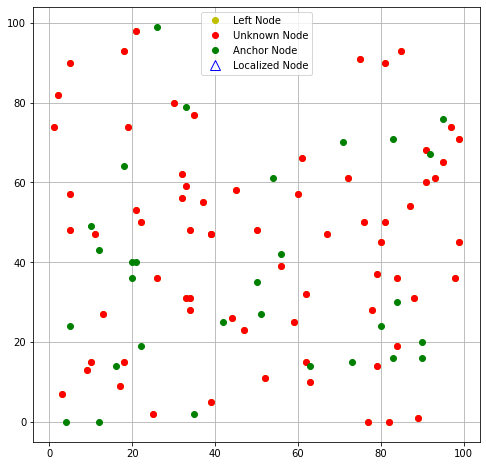

In [334]:
coco.show_field()

In [335]:
coco.main()

In [336]:
coco.X_loc

[[[81.24264776730759, 50.06964071634424], array([81, 50])],
 [[66.83691657455878, 46.922066866006986], array([67, 47])],
 [[18.01970026996785, 15.444335641443596], array([18, 15])],
 [[25.601077011666472, 35.36294167643053], array([26, 36])],
 [[79.76058129409925, 44.87172283161318], array([80, 45])],
 [[32.53781647800844, 58.7455488579103], array([33, 59])],
 [[36.659415323918644, 54.451034743621705], array([37, 55])],
 [[49.854834325329534, 47.71278200329988], array([50, 48])],
 [[98.37802147288774, 71.00583500647573], array([99, 71])],
 [[60.0267143453285, 56.41786088708384], array([60, 57])],
 [[62.27547794373996, 15.94695495731207], array([62, 15])],
 [[62.455483245906215, 32.236365909563034], array([62, 32])],
 [[5.598855612059033, 47.65638494101855], array([ 5, 48])],
 [[81.75080463962563, 1.2020520889360173], array([82,  0])],
 [[90.44022791160958, 69.99937092183704], array([91, 68])],
 [[38.95228372341202, 46.61187632374604], array([39, 47])],
 [[31.66494616736809, 55.23756880

In [337]:
distances = []
for loc in coco.X_loc:
    modified = loc[0]
    original = loc[1]
    
    distances.append(np.sqrt((modified[0] - original[0])**2 + (modified[1] - original[1])**2))

In [338]:
np.sum(distances)/len(distances)

0.6784531577723476

In [339]:
len(distances)

70

In [340]:
len(coco.F_mins)

1612

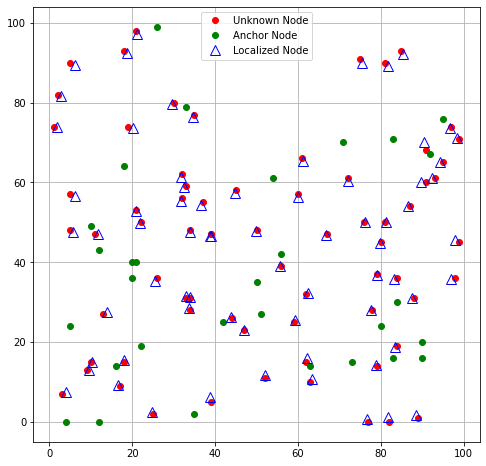

In [341]:
coco.show_field()

In [358]:
# Plot Test
# plt.plot(54,88, 'b^', fillstyle='none', markersize = 10)
# plt.plot(54,88, 'go')

# plt.grid()

# PLOTS

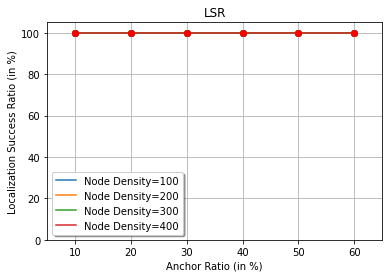

In [350]:
# IMPROVED
# lsr graph (Anc. Ratio)
anc_density = [10, 20, 30, 40, 50, 60]
lsr_100 = [100, 100, 100, 100, 100, 100]
lsr_200 = [100, 100, 100, 100, 100, 100]
lsr_300 = [100, 100, 100, 100, 100, 100]
lsr_400 = [100, 100, 100, 100, 100, 100]

plt.xlabel("Anchor Ratio (in %)")
plt.ylabel("Localization Success Ratio (in %)")
plt.title("LSR")

plt.plot(anc_density, lsr_100, label="Node Density=100")
plt.plot(anc_density, lsr_100, 'bo')
plt.plot(anc_density,lsr_200, label="Node Density=200")
plt.plot(anc_density, lsr_200, 'yo')
plt.plot(anc_density,lsr_300, label="Node Density=300")
plt.plot(anc_density, lsr_300, 'go')
plt.plot(anc_density,lsr_400, label="Node Density=400")
plt.plot(anc_density, lsr_400, 'ro')

plt.legend(shadow='true')
plt.axis([5,65,0,105])
plt.grid()
plt.show()

# IMPROVED
# # lsr graph (T Range)
# trans_range = [10, 20, 30, 40, 50]
# # lsr_100 = [0, 17.5, 32.5, 100, 100]
# # lsr_200 = [8.125, 63.7499, 100, 100, 100]
# # lsr_300 = [17.91, 80.833, 100, 100, 100]
# # lsr_400 = [31.5625, 87.5, 100, 100, 100]

# plt.xlabel("Communication Range (meters)")
# plt.ylabel("Localization Success Ratio (in %)")
# plt.title("LSR")

# plt.plot(trans_range, lsr_100, label="Node Density=100")
# plt.plot(trans_range, lsr_100, 'bo')
# plt.plot(trans_range, lsr_200, label="Node Density=200")
# plt.plot(trans_range, lsr_200, 'yo')
# plt.plot(trans_range, lsr_300, label="Node Density=300")
# plt.plot(trans_range, lsr_300, 'go')
# plt.plot(trans_range, lsr_400, label="Node Density=400")
# plt.plot(trans_range, lsr_400, 'ro')

# plt.legend(shadow='true')
# plt.axis([5,55,-5,105])
# plt.grid()
# plt.show()

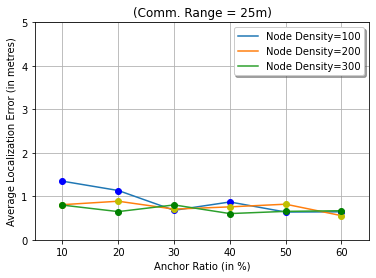

In [2]:
# IMPROVED
# ALE graph (Anc. Ratio)

anc_density = [10, 20, 30, 40, 50, 60]
ale_100 = [1.34785,1.13364,0.678453,0.869726,0.638012,0.643762]
ale_200 = [0.807768,0.886961,0.705345,0.757282,0.818754,0.555292]
ale_300 = [0.79762,0.648343,0.801926,0.602969,0.653686,0.668649]
# ale_400 = []

plt.xlabel("Anchor Ratio (in %)")
plt.ylabel("Average Localization Error (in metres)")
plt.title("(Comm. Range = 25m)")

plt.plot(anc_density, ale_100, label="Node Density=100")
plt.plot(anc_density, ale_100, 'bo')
plt.plot(anc_density, ale_200, label="Node Density=200")
plt.plot(anc_density, ale_200, 'yo')
plt.plot(anc_density, ale_300, label="Node Density=300")
plt.plot(anc_density, ale_300, 'go')
# plt.plot(anc_density, ale_400, label="Node Density=400")
# plt.plot(anc_density, ale_400, 'ro')

plt.legend(shadow='true')
plt.axis([5,65,0,5])
plt.grid()
plt.show()

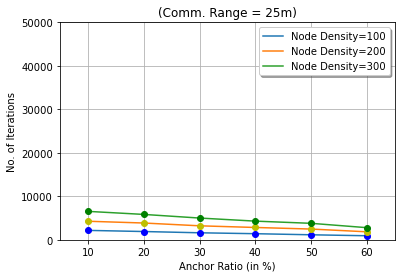

In [7]:
# IMPROVED
# no. of iterations graph (Anc. Ratio)

anc_density = [10, 20, 30, 40, 50, 60]
n_iter_100 = [2165,1902,1612,1403,1152,930]
n_iter_200 = [4266,3859,3217,2835,2471,1836]
n_iter_300 = [6538,5836,5001,4294,3788,2787]
# n_iter_400 = []

plt.xlabel("Anchor Ratio (in %)")
plt.ylabel("No. of Iterations")
plt.title("(Comm. Range = 25m)")

plt.plot(anc_density, n_iter_100, label="Node Density=100")
plt.plot(anc_density, n_iter_100, 'bo')
plt.plot(anc_density, n_iter_200, label="Node Density=200")
plt.plot(anc_density, n_iter_200, 'yo')
plt.plot(anc_density, n_iter_300, label="Node Density=300")
plt.plot(anc_density, n_iter_300, 'go')
# plt.plot(anc_density, n_iter_400, label="Node Density=400")
# plt.plot(anc_density, n_iter_400, 'ro')

plt.legend(shadow='true')
plt.axis([5,65,0,50000])
plt.grid()
plt.show()

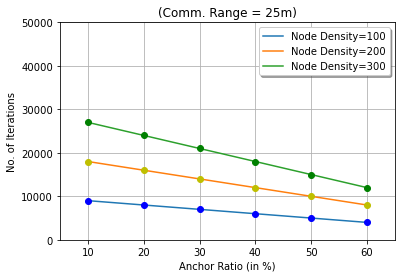

In [6]:
# IMPROVED
# no. of iterations graph (Anc. Ratio)

anc_density = [10, 20, 30, 40, 50, 60]
n_iter_100 = [9000,8000,7000,6000,5000,4000]
n_iter_200 = [18000,16000,14000,12000,10000,8000]
n_iter_300 = [27000,24000,21000,18000,15000,12000]
# n_iter_400 = []

plt.xlabel("Anchor Ratio (in %)")
plt.ylabel("No. of Iterations")
plt.title("(Comm. Range = 25m)")

plt.plot(anc_density, n_iter_100, label="Node Density=100")
plt.plot(anc_density, n_iter_100, 'bo')
plt.plot(anc_density, n_iter_200, label="Node Density=200")
plt.plot(anc_density, n_iter_200, 'yo')
plt.plot(anc_density, n_iter_300, label="Node Density=300")
plt.plot(anc_density, n_iter_300, 'go')
# plt.plot(anc_density, n_iter_400, label="Node Density=400")
# plt.plot(anc_density, n_iter_400, 'ro')

plt.legend(shadow='true')
plt.axis([5,65,0,50000])
plt.grid()
plt.show()

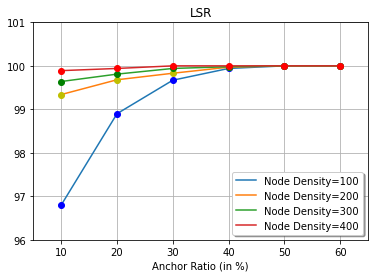

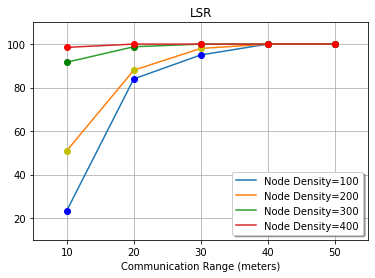

In [354]:
# BASE
# lsr graph (Anc. Ratio)
anc_density = [10, 20, 30, 40, 50, 60]
# lsr_100 = [97, 99.35, 99.73, 99.99, 100, 100]
# lsr_200 = [99.71, 99.90, 100, 100, 100, 100]
# lsr_300 = [99.94, 99.98, 100, 100, 100, 100]
# lsr_400 = [100, 100, 100, 100, 100, 100]

lsr_100 = [96.8, 98.9, 99.67, 99.94, 100, 100]
lsr_200 = [99.34, 99.68, 99.83, 99.97, 100, 100]
lsr_300 = [99.64, 99.81, 99.94, 99.98, 100, 100]
lsr_400 = [99.89, 99.94, 100, 100, 100, 100]

plt.xlabel("Anchor Ratio (in %)")
# plt.ylabel("Localization Success Ratio")
plt.title("LSR")

plt.plot(anc_density, lsr_100, label="Node Density=100")
plt.plot(anc_density, lsr_100, 'bo')
plt.plot(anc_density,lsr_200, label="Node Density=200")
plt.plot(anc_density, lsr_200, 'yo')
plt.plot(anc_density,lsr_300, label="Node Density=300")
plt.plot(anc_density, lsr_300, 'go')
plt.plot(anc_density,lsr_400, label="Node Density=400")
plt.plot(anc_density, lsr_400, 'ro')

plt.legend(shadow='true')
plt.axis([5,65,96,101])
plt.grid()
plt.show()

# BASE
# lsr graph (T Range)
trans_range = [10, 20, 30, 40, 50]
lsr_100 = [23.45, 84, 95, 100, 100]
lsr_200 = [51, 88, 98, 100, 100]
lsr_300 = [91.68, 98.77, 100, 100, 100]
lsr_400 = [98.5, 100, 100, 100, 100]

plt.xlabel("Communication Range (meters)")
# plt.ylabel("Localization Success Ratio")
plt.title("LSR")

plt.plot(trans_range, lsr_100, label="Node Density=100")
plt.plot(trans_range, lsr_100, 'bo')
plt.plot(trans_range, lsr_200, label="Node Density=200")
plt.plot(trans_range, lsr_200, 'yo')
plt.plot(trans_range, lsr_300, label="Node Density=300")
plt.plot(trans_range, lsr_300, 'go')
plt.plot(trans_range, lsr_400, label="Node Density=400")
plt.plot(trans_range, lsr_400, 'ro')

plt.legend(shadow='true')
plt.axis([5,55,10,110])
plt.grid()
plt.show()

c:\users\kotiyal\appdata\local\programs\python\python37-32\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


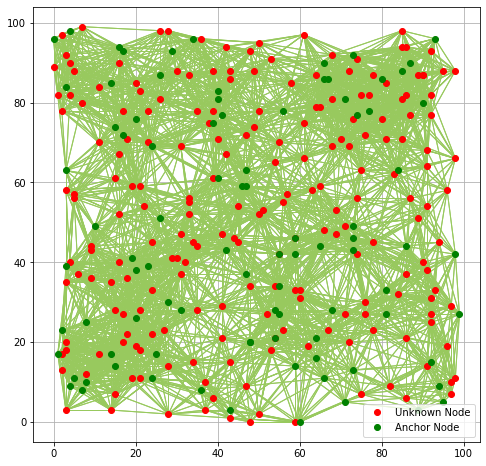

In [21]:
# Connectivity Graphs

t_range = 20
total_nodes = 300
anchor_percent = 0.30
N = int((1 - anchor_percent) * total_nodes) # unknown nodes
M = total_nodes - N # anchor nodes

# anchor nodes random placement
X_anchor = []

for i in range(M):
    x_anchor = np.random.randint(100)
    y_anchor = np.random.randint(100)

    X_anchor.append([x_anchor, y_anchor])

# unknown nodes random placement
X_unknown = []
for i in range(N):
    x_unknown = np.random.randint(100)
    y_unknown = np.random.randint(100)
  
    X_unknown.append([x_unknown, y_unknown])

X_unknown = np.array(X_unknown)
X_anchor = np.array(X_anchor)

#plot
plt.figure(figsize=(8, 8))

X_all = []
for i in X_unknown:
    X_all.append(i)
for i in X_anchor:
    X_all.append(i)
X_all = np.array(X_all)
    
for i in X_all:
    for j in X_all:
            if not all (i==j):
                d = np.power(((i[0] - j[0])**2 + (i[1] - j[1])**2), 0.5)
                if d < t_range:
                    plt.plot([i[0], j[0]], [i[1], j[1]], '-', color="#98c95e", linewidth=1)
#                     plt.plot([i[0], j[0]], [i[1], j[1]], '-', color="#000000", linewidth=1)

plt.plot(X_unknown[:, 0], X_unknown[:, 1], 'ro', label="Unknown Node")
plt.plot(X_anchor[:, 0], X_anchor[:, 1], 'go', label="Anchor Node")

        
plt.legend()
plt.grid()
plt.show()